# 单模型实现

如果没对异常数据剔除，请见另外一个文件：detection_remove.ipynb， 执行完后，走下面的步骤

In [1]:
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
import os
os.chdir("{}/image".format(os.getcwd()))

Using TensorFlow backend.


# 加载数据集

In [2]:
import cv2
import os
import numpy as np
from tqdm import tqdm


img_size = 224
def load_train(img_size):
    
    train = os.listdir('train')
    n = len(train)
    X = np.zeros((n, img_size, img_size, 3), dtype=np.uint8)
    y = np.zeros((n, 1), dtype=np.uint8) # cat = 0 , dog = 1
    for i, filename in zip(tqdm(range(n)), train):
        name = filename[0: 3]
        if(name == 'cat'):
            y[i] = 0 
        elif(name == 'dog'):
            y[i] = 1 
        else:
            return
        X[i] = cv2.resize(cv2.imread('train/%s' % filename), (img_size, img_size))
        
    return X,y

X, y = load_train(img_size)
print("训练样本加载完成，训练集图片数量：{}".format(len(X)))

100%|██████████| 24977/24977 [07:11<00:00, 57.86it/s]

训练样本加载完成，训练集图片数量：24977


# 分为训练集和验证集

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

# 构建模型

https://github.com/fchollet/keras/blob/master/keras/applications/resnet50.py


In [4]:
base_model = ResNet50(input_tensor=Input((224, 224, 3)), weights='imagenet', include_top=False)

for layers in base_model.layers:
    layers.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.25)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(base_model.input, x)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [5]:
model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 训练模型

In [8]:
print('ResNet50 - optimizer=adadelta - batch_size=128')
model_trained = model.fit(X_train, y_train, batch_size=128, epochs=8, validation_data=(X_valid, y_valid))

ResNet50 - optimizer=adadelta - batch_size=128
Train on 19981 samples, validate on 4996 samples
Epoch 1/8
19981/19981 [==============================] - 1478s 74ms/step - loss: 0.0471 - acc: 0.9819 - val_loss: 0.0499 - val_acc: 0.9822
Epoch 2/8
19981/19981 [==============================] - 1495s 75ms/step - loss: 0.0473 - acc: 0.9825 - val_loss: 0.0530 - val_acc: 0.9812
Epoch 3/8
19981/19981 [==============================] - 1490s 75ms/step - loss: 0.0457 - acc: 0.9830 - val_loss: 0.0480 - val_acc: 0.9832
Epoch 4/8
19981/19981 [==============================] - 1489s 75ms/step - loss: 0.0460 - acc: 0.9828 - val_loss: 0.0479 - val_acc: 0.9836
Epoch 5/8
19981/19981 [==============================] - 1494s 75ms/step - loss: 0.0445 - acc: 0.9834 - val_loss: 0.0474 - val_acc: 0.9836
Epoch 6/8
19981/19981 [==============================] - 1495s 75ms/step - loss: 0.0446 - acc: 0.9833 - val_loss: 0.0484 - val_acc: 0.9830
Epoch 7/8
19981/19981 [==============================] - 1485s 74ms/st

绘制模型训练收敛曲线

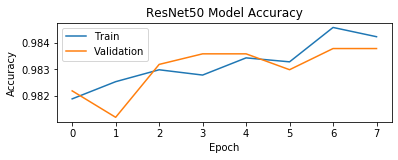

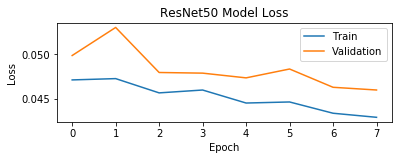

0.9837(max: 0.9837)
Done.


In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

# matplotlib.use('ggplot') #绘图风格设置

# Plot accuracy
plt.subplot(211)
plt.plot(model_trained.history['acc'])
plt.plot(model_trained.history['val_acc'])
plt.title('ResNet50 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.figure()

# Plot loss
plt.subplot(212)
plt.plot(model_trained.history['loss'])
plt.plot(model_trained.history['val_loss'])
plt.title('ResNet50 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()

# plt.tight_layout(h_pad=1.0)
# plt.savefig('/history-graph.png')

print(str(model_trained.history['val_acc'][-1])[:6] +
      "(max: " + str(max(model_trained.history['val_acc']))[:6] + ")")
print("Done.")

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
# 画图
def plot_training(history, model_name):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.legend(["acc", "val_acc"], loc='best')
    plt.title('{} Model accuracy'.format(model_name))
    plt.figure()

    loss = history.history['loss']
    val_loss = history.history['val_loss']   
    plt.plot(epochs, loss, 'b')
    plt.plot(epochs, val_loss, 'r')
    plt.legend(["loss", "val_loss"], loc='best')
    plt.title('{} Model loss'.format(model_name))
    plt.show()
    print(str(history.history['val_acc'][-1])[:6] +
      "(max: " + str(max(history.history['val_acc']))[:6] + ")")
    print("Done.")


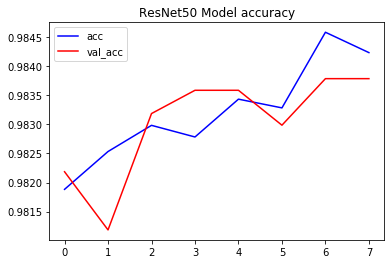

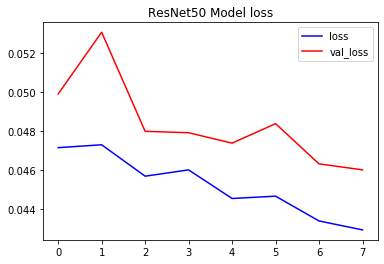

0.9837(max: 0.9837)
Done.


In [25]:
# 训练的acc_loss图
plot_training(model_trained, 'ResNet50')

# 可视化模型

https://keras.io/visualization/

In [18]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [19]:
zip([x.name for x in model.layers], range(len(model.layers)))

# Fine-tune

http://keras-cn.readthedocs.io/en/latest/blog/image_classification_using_very_little_data/

In [26]:
for layer in model.layers[140:]:
    layer.trainable = True

In [28]:
print('ResNet50 - optimizer=adadelta - batch_size=128 - fine-tune')
model.fit(X_train, y_train, batch_size=128, epochs=8, validation_data=(X_valid, y_valid))

ResNet50 - optimizer=adadelta - batch_size=128 - fine-tune
Train on 19981 samples, validate on 4996 samples
Epoch 1/8
19981/19981 [==============================] - 1484s 74ms/step - loss: 0.0411 - acc: 0.9856 - val_loss: 0.0457 - val_acc: 0.9840
Epoch 2/8
19981/19981 [==============================] - 1495s 75ms/step - loss: 0.0421 - acc: 0.9846 - val_loss: 0.0470 - val_acc: 0.9834
Epoch 3/8
19981/19981 [==============================] - 1493s 75ms/step - loss: 0.0409 - acc: 0.9845 - val_loss: 0.0466 - val_acc: 0.9840
Epoch 4/8
19981/19981 [==============================] - 1499s 75ms/step - loss: 0.0399 - acc: 0.9850 - val_loss: 0.0452 - val_acc: 0.9838
Epoch 5/8
19981/19981 [==============================] - 1491s 75ms/step - loss: 0.0389 - acc: 0.9865 - val_loss: 0.0475 - val_acc: 0.9828
Epoch 6/8
19981/19981 [==============================] - 1485s 74ms/step - loss: 0.0377 - acc: 0.9860 - val_loss: 0.0453 - val_acc: 0.9838
Epoch 7/8
19981/19981 [==============================] - 1

In [29]:
model.save('resnet50_model.h5')

In [35]:
def load_test(n,img_size):
    X = np.zeros((n, img_size, img_size, 3), dtype=np.uint8)

    for i in tqdm(range(n)):
        #test图片从1.jpg开始
        X[i] = cv2.resize(cv2.cvtColor(cv2.imread('test/%d.jpg' % (i+1)), cv2.COLOR_BGR2RGB), (img_size, img_size)) 
    return X

X_test = load_test(12500,224)

100%|██████████| 12500/12500 [05:28<00:00, 38.11it/s]


In [36]:
import pandas as pd
from keras.preprocessing.image import *

df = pd.read_csv("sample_submission.csv")

image_size = (224, 224)
gen = ImageDataGenerator()
test_generator = gen.flow_from_directory("img_test", image_size, shuffle=False, 
                                         batch_size=16, class_mode=None)

y_pred = model.predict(X_test, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)

for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.set_value(index-1, 'label', y_pred[i])

df.to_csv('resnet50_pred.csv', index=None)
df.head(10)

Found 12500 images belonging to 1 classes.
12500/12500 [==============================] - 726s 58ms/step


/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  app.launch_new_instance()


,id,label
0,1,0.995000
1,2,0.995000
2,3,0.995000
3,4,0.005000
4,5,0.693693
5,6,0.995000
6,7,0.995000
7,8,0.995000
8,9,0.005000
9,10,0.995000
